# Outline of Variance Reduction Techinques
## Control Variates

* Step 1: Discretize the setup with N steps and M paths
\begin{equation}
\begin{split}
&t= t_0, \cdots, t_N;\\
&m=1, \cdots, M.
\end{split}
\end{equation}
* Step 2: Draw two random samples $Z_1$ and $Z_2$ from a standard normal distribution $N(0,1)$:
\begin{equation} 
\begin{split}
&Z_{t,1} \sim N(0,1), \\
&Z_{t,2} = -Z_{t,1}
\end{split}
\end{equation}
* Step 3: Simulate log stock prices seperatedly by applying a Euler schema:
\begin{equation}
\begin{split}
&\ln S^1_{t+\triangle} = \ln S^1_t + (r-\frac{1}{2}\sigma^2)\times \triangle+ \sigma\times \sqrt{\triangle}\times Z_{t,1},\\
&\ln S^2_{t+\triangle} = \ln S^2_t + (r-\frac{1}{2}\sigma^2)\times \triangle+ \sigma\times \sqrt{\triangle}\times Z_{t,2},\\
\end{split}
\end{equation}
* Step 4: Work out the target samples of stock prices:
\begin{equation} 
S_{t+\triangle} = \frac{S^1_{t+\triangle} + S^2_{t+\triangle}}{2}
\end{equation}


## Antithetic Method
* The main steps are the same as those steps in the method of control variate, except the sampling of the two random variables:
\begin{equation} 
\begin{split}
& u \sim U[0,1], \\
&Z_{t,1} \sim N^{-1}(u), \\
&Z_{t,2} \sim N^{-1}(1-u).
\end{split}
\end{equation}
* The simulation steps are the same as those in the control-variates method.

In [1]:
# Tasks:
# Setup
#           dS/S = r*dt + sigma*dW
#           dB/B = r*dt

# 1) Simulating S with variance reduction techniques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
 

def EulerMilsteinMCStock(scheme, parameters):
    np.random.seed(1000)

    # time setup
    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    S_0 = parameters['model']['S0']  # initial value
    sigma = parameters['model']['sigma']  # initial value
    rf = parameters['model']['rf']  # initial value    

    # simulation    
    S = np.zeros((numSteps + 1, numPaths),dtype=float)
    S[0,:] = np.log(S_0)
  
    ################         simluations for asset price S              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            # the random number following a standard normal distribution with mean 0 and varaince 1 is sampled
            Zs = np.random.normal(0, 1, 1)                        
            
            if scheme == 'Euler':
                S[t_step,i] = S[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs 
            elif scheme == 'Milstein':    
                # Euler and Milstein have the same discretization scheme for Log(S) due to dsigma(t,X)/dX =0
                # dlns = (r-sigma^2/2)dt + sigma*dW
                S[t_step,i] = S[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs                                
            
    return np.exp(S)

def EulerMilsteinMCStock_Control(scheme, parameters):
    
    np.random.seed(1000)

    # time setup
    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    S_0 = parameters['model']['S0']  # initial value
    sigma = parameters['model']['sigma']  # initial value
    rf = parameters['model']['rf']  # initial value    

    # simulation    
    S1 = np.zeros((numSteps + 1, numPaths),dtype=float)
    S1[0,:] = np.log(S_0)
    
    S2 = np.zeros((numSteps + 1, numPaths),dtype=float)
    S2[0,:] = np.log(S_0)
  
    ################         simluations for asset price S              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            # the random number following a standard normal distribution with mean 0 and varaince 1 is sampled
            Zs = np.random.normal(0, 1, 1)
            Zs_minus = -Zs 
            
            if scheme == 'Euler':
                S1[t_step,i] = S1[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs 
                S2[t_step,i] = S2[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_minus 
            elif scheme == 'Milstein':    
                # Euler and Milstein have the same discretization scheme for Log(S) due to dsigma(t,X)/dX =0
                S1[t_step,i] = S1[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs  
                S2[t_step,i] = S2[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_minus 
            
    return np.exp(S1), np.exp(S2), (np.exp(S1)+ np.exp(S2))/2
    
def EulerMilsteinMCStock_Antithetic(scheme, parameters):  
    
    np.random.seed(1000)

    # time setup
    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    S_0 = parameters['model']['S0']  # initial value
    sigma = parameters['model']['sigma']  # initial value
    rf = parameters['model']['rf']  # initial value    

    # simulation    
    S1 = np.zeros((numSteps + 1, numPaths),dtype=float)
    S1[0,:] = np.log(S_0)
    
    S2 = np.zeros((numSteps + 1, numPaths),dtype=float)
    S2[0,:] = np.log(S_0)
    
    #S3 = np.zeros((numSteps + 1, numPaths),dtype=float)
    #S3[0,:] = np.log(S_0)
  
    ################         simluations for asset price S              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            # the random number following a standard normal distribution with mean 0 and varaince 1 is sampled
            U1 = np.random.rand()  # r.v. from uniform distribution
            Zs_1 = norm.ppf(U1)  # inverse function of a normal distribution
            Zs_2 = norm.ppf(1-U1)            
            #Zs_3 = (Zs_1+Zs_2)/2
            #print('Zs_1=%f, Zs_2=%f, Zs_3=%f'%(Zs_1,Zs_2,Zs_3))
            
            if scheme == 'Euler':
                S1[t_step,i] = S1[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_1 
                S2[t_step,i] = S2[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_2 
                #S3[t_step,i] = S3[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_3
            elif scheme == 'Milstein':    
                # Euler and Milstein have the same discretization scheme for Log(S) due to dsigma(t,X)/dX =0
                S1[t_step,i] = S1[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_1  
                S2[t_step,i] = S2[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_2 
                #S3[t_step,i] = S3[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs_3 
            
    return np.exp(S1), np.exp(S2), (np.exp(S1)+ np.exp(S2))/2

if __name__=="__main__": # main function
    
    S0 = 100
    sigma = 0.20
    K = 100
    rf = 0.05    
    T = 1     # maturity
    
    # discrete setup
    N = 100  # steps
    dt = T/N
    M = 200
    
    Optype = 1 # 1: call -1: put 

    parameters = {'model':{'S0':S0, 'sigma':sigma, 'rf':rf},                 
                  'asset':{'K':K, 'optype': Optype},
                  'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M}                
                 }
    # Task 1
    # simulate stock prices
    Sim_S = EulerMilsteinMCStock('Euler', parameters)
    print(np.std(Sim_S[-1,:]))
    
    [Sim_S1, Sim_S2, Sim_S3] = EulerMilsteinMCStock_Control('Euler', parameters)
    print(np.std(Sim_S1[-1,:]),np.std(Sim_S2[-1,:]), np.std(Sim_S3[-1,:]))
    
    [Sim_S4, Sim_S5, Sim_S6] = EulerMilsteinMCStock_Antithetic('Euler', parameters)
    print(np.std(Sim_S4[-1,:]),np.std(Sim_S5[-1,:]), np.std(Sim_S6[-1,:]))
 


22.68749069233732
22.68749069233732 23.206293073677 3.304362134352882
23.2008882476815 21.879102279429308 4.073146635522708


# Outline of Delta-Neutral and Gamma-Delta-Neutral Hedging

The purpose of both hedging strategies is to replicate the payoff to the target option (opiton #1). Certainly, it is just for the demontration. In the Black-Scholes model, we can investigate the performance of hedging strategies. 

## Underlying Logic
* Considering a portfolio consisting of two options ($O_1$ and $O_2$), stock shares ($S$), and bond account ($B$) with the following positions:
  * $n_{c_1}$ presents the trading positions in the first option $C_1$
  * $n_s$ presents the trading positions in the stock
  * $n_b$ presents the cash amount in the bond account
  * $k$ presents the trading position in the second option $C_2$
(note that the option #1 or #2 can be a call or put, undering the same stock, but subject to the specification of option type.)
and there are two cases:
* With this setup, the value of the self-financing portfolio $\prod$ can be worked out as follows:
\begin{equation}
\prod(t) = n_{c_1} \times O_1(S,t) + n_s \times S_t + n_b \times B_t + k \times O_2(S,t)................          (1)
\end{equation}
Now, the first derivative of $\prod$ with respect to $S$ yields the following:
\begin{equation}
\frac{\partial \prod(t) }{\partial S_t} =   n_{c_1} \times \frac{\partial O_1(S,t) }{\partial S_t} + n_s + 0 + k \times \frac{\partial O_2(S,t) }{\partial S_t}.....................              (2)
\end{equation}
and further the second derivative of $\prod$ with respect to $S$ yields the following:
\begin{equation}
\frac{\partial^2 \prod(t) }{\partial S^2_t} =   n_{c_1} \times \frac{\partial^2 O_1(S,t) }{\partial S^2_t} + 0 + 0 + k \times \frac{\partial^2 O_2(S,t) }{\partial S^2_t}.....................             (3)
\end{equation}
By setting $\frac{\partial^2 \prod(t) }{\partial S^2_t}=0$ in Equation (3), we may work out the value of $k$ as follows:
\begin{equation}
k = - n_{c_1} \frac{\frac{\partial^2 O_1(S,t) }{\partial S^2_t}}{\frac{\partial^2 O_2(S,t) }{\partial S^2_t}}  = -n_{c_1} \frac{\Gamma_{O_1}}{\Gamma_{O_2}}
\end{equation}
Moreover, by setting $\frac{\partial \prod(t) }{\partial S_t}=0$ in Equation (2), we may work out the value of $n_s$ as follows:
\begin{equation}
 n_s = - n_{c_1} \times \frac{\partial O_1(S,t) }{\partial S_t} - k \times \frac{\partial O_2(S,t) }{\partial S_t} = - n_{c_1} \Delta_{O_1} - k \Delta_{O_2}.
\end{equation}
Finally, by setting $\prod(t)=0$ in Equaiton (1), we may work out the amount of cash account $n_b$ as follows:
\begin{equation}
 n_b = -\frac{1}{B_t}(n_{c_1} \times O_1(S,t) + n_s \times S_t + k \times O_2(S,t)).
\end{equation}
* Case 1: The position in the second option is zero, e.g. $k=0$, which leads to the delta-netural trading strategy.
* Case 2: The position in the second option is zero, e.g. $k\neq 0$, which leads to the delta-gamma-neutral trading strategy.

## Delta-Neutral Hedging
Now we are working on a delta-neutral hedging strategy by taking $n_{c_1}=-1$ for a CALL option with the following steps: 
(note that the steps can be adjusted with the different choice of options.)
* Step 1: Based on this log process, simulate the log stock prices over $[0,T]$ by applying a Euler schema:
\begin{equation}
\ln S_{t+\triangle}- \ln S_t = (r-\frac{1}{2}\sigma^2)\times \triangle+ \sigma\times \sqrt{\triangle}\times Z_{t}
\end{equation}
where $t= t_0,\cdots, t_N$, $\triangle=T/N$ and $Z_t \sim N(0,1)$. This may generate an $(N+1)\times M$ matrix, where ''$+1$''means the inclusion of the initial price at time zero:
\begin{equation}
S = 
\left(%
\begin{array}{cccc}
  \ln S^1_0 & \ln S^2_0 & \cdots & \ln S^M_0 \\
  \ln S^1_1 & \ln S^2_1 & \cdots & \ln S^M_1 \\
  \vdots & \vdots & \vdots & \vdots \\
  \ln S^1_N & \ln S^2_N & \cdots & \ln S^M_N \\
\end{array}%
\right)
\end{equation}
Note that $M$ denotes the number of simulation paths, and $N$ presents the number of time steps (from now on). 

* Step 2: Work out those hedging positions in component assets in the portfolio:
\begin{equation}
\begin{split}
&n_c = -1,\\
&n_s = \triangle_c = N(d_1),\\
&n_b = C(0) - n_s\times S(0),
\end{split}
\end{equation}
and $\triangle_c = \frac{\partial C(t)}{\partial S_t}= N(d_1)$.  

* Step 3: In Step i ($i\in [1, N-1]$, work out the time-t option price with the updated time-to-maturity $\tau = T-- i\times \triangle t$ by appling the Black-Scholes formula:
\begin{equation}
C(S_{t_i},K, \sigma, S_{t_i}, T,r_f) = S_t N(d_1) - K e^{-r_f*\tau} N(d_2),
\end{equation}
where $$d_1 = \frac{\ln(S_{t_i}/K) + (r_f + \frac{1}{2}\sigma^2)\tau}{\sigma \sqrt{\tau}}$$ and $$d_2 = d_1 -\sigma \sqrt{\tau}$$. And the payoff to this option at the maturity $t=t_N$:
\begin{equation}
C(S_{t_N},K) = \max(S_{t_N} - K, 0).
\end{equation}

* Step 4: In Step i ($i\in [1, N]$, work out the value of the hedging portfolio：
\begin{equation}
\prod(t_i) = n_{c_1} \times C(S,t_i) + n_s \times S_{t_i} + n_b \times B_t\times (1+r_f* i\times \triangle t). 
\end{equation}

## Gamma-Delta-Neutral Hedging
Now we are working on a delta-gamma neutral hedging strategy by taking $n_{c_1}=-1$ for a CALL option with the following steps: 
(note that the steps can be adjusted with the different choice of options,and the time-to-maturity of the second option is equal to $T_1>T$.)
* Step 1: Based on this log process, simulate the log stock prices over $[0,T]$ by applying a Euler schema (see the above).
* Step 2: Work out those hedging positions in component assets in the portfolio:
\begin{equation}
\begin{split}
&n_c = -1,\\
&k =  -n_{c_1} \frac{\Gamma_{C}}{\Gamma_{O_2}},\\
&n_s = - n_{c_1} \Delta_{C} - k \Delta_{O_2},\\
&n_b =  -(n_c C(S,0) + n_s \times S_0 + k \times O_2(S,0)),\\
\end{split}
\end{equation}
and $\triangle_c = \frac{\partial C(t)}{\partial S_t}= N(d_1)$ and $\Gamma_c =  \frac{\partial^2 C(t)}{\partial S^2_t}$.

* Step 3: In Step i ($i\in [1, N-1]$, work out the time-t option prices for two options with the updated time-to-maturity $\tau = T-- i\times \triangle t$  and $\tau_1 = T_1-- i\times \triangle t$ by appling the Black-Scholes formula:
\begin{equation}
\begin{split}
C(S_{t_i},K, \sigma, S_{t_i}, T,r_f) = S_t N(d_1) - K e^{-r_f*\tau} N(d_2),\\
C(S_{t_i},K, \sigma, S_{t_i}, T_1,r_f) = S_t N(d_1') - K e^{-r_f*\tau_1} N(d_2'),
\end{split}
\end{equation}
where $d_1, d_2, d_1', d_2'$ are defined in the same way described above with the different time-to-maturities. And the payoff to the first  option at the maturity $t=t_N=T$:
\begin{equation}
C(S_{t_N},K) = \max(S_{t_N} - K, 0).
\end{equation}

* Step 4: In Step i ($i\in [1, N]$, work out the value of the hedging portfolio：
\begin{equation}
\prod(t_i) = n_{c_1} \times C(S,t_i) + n_s \times S_{t_i} + n_b \times B_t\times (1+r_f* i\times \triangle t) + k \times O_2(S,t_i)
\end{equation}



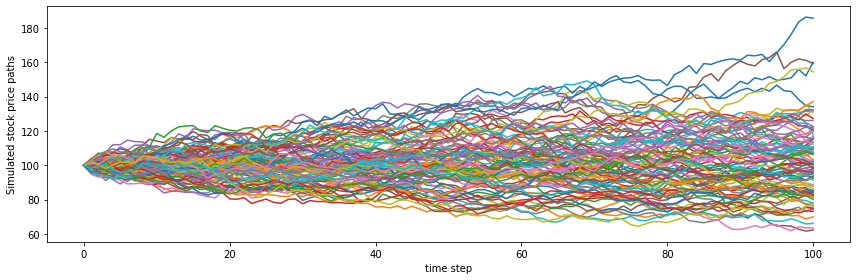

parameter_1=

{'model': {'S0': 100, 'sigma': 0.2, 'rf': 0.05}, 'asset': {'K': 100, 'optype': 1}, 'option': {'K': 100, 'optype': 1, 'T': 1}, 'setup': {'T': 1, 'numSteps': 100, 'dt': 0.01, 'numPaths': 100}, 'strategy': {'n_c': -1, 'n_s': 0.6368306511756191, 'n_b': -53.232481545376345, 'k': 0}}
parameter_2=

{'model': {'S0': 100, 'sigma': 0.2, 'rf': 0.05}, 'asset': {'K': 100, 'optype': 1}, 'option': {'K': 100, 'optype': 1, 'T': 2}, 'setup': {'T': 1, 'numSteps': 100, 'dt': 0.01, 'numPaths': 100}, 'strategy': {'n_c': -1, 'n_s': -0.400148704518288, 'n_b': 26.21816502175756, 'k': 1.5035418983679911}}
option_1=10.450584 vs option_2 = 16.126780
delta_1=0.636831 vs delta_2=0.689691
gamma_1=0.018762 vs gamma_2=0.012479


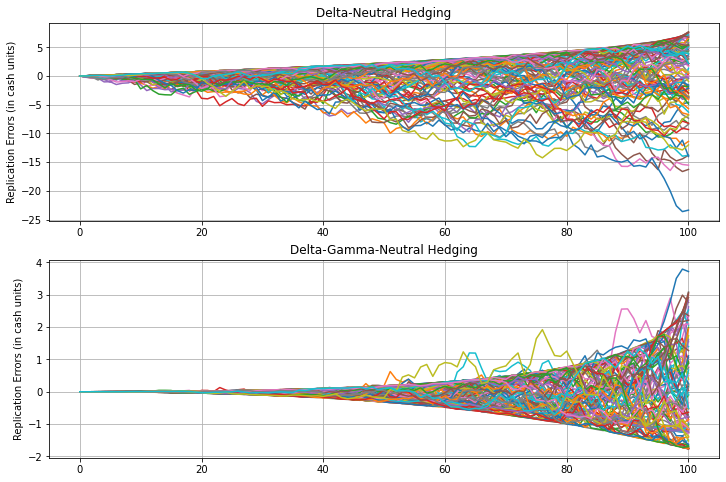

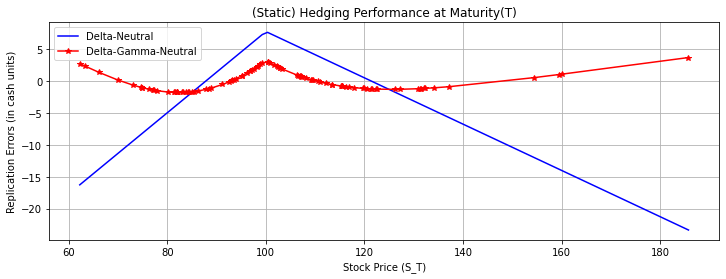

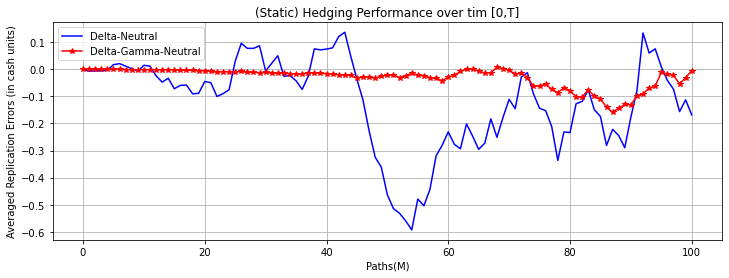

In [2]:
# Tasks:
# Setup
#           dS/S = r*dt + sigma*dW
#           dB/B = r*dt

# 1) implement static delta-neutral strategy in MC
# 2) implement static delta-gamma-neutral strategy in MC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def Black_ScholesPrice(parameters):

    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']    
    rf = parameters['model']['rf']  
    
    K = parameters['option']['K']    
    T = parameters['option']['T']
    option_type = parameters['option']['optype'] 
    
    DF = np.exp(-rf*T)
    
    d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    #print('S0=%f, K=%f, sigm=%f, T= %f, d1=%f vs d2=%f'%(S0, K,sigma, T, d1,d2))

    if option_type == 1:  # call
        option_price = S0 * norm.cdf(d1) - K * DF * norm.cdf(d2)
    elif option_type == -1: # put
        option_price = K * DF * norm.cdf(-d2) - S0 * norm.cdf(-d1) 
    
    return option_price

def Black_ScholesPrice_Paras(St, K, sigma, T, rf, option_type):

    DF = np.exp(-rf*T)
    
    d1 = (np.log(St/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 1:  # call
        option_price = St * norm.cdf(d1) - K * DF * norm.cdf(d2)
    elif option_type == -1: # put
        option_price = K * DF * norm.cdf(-d2) - St * norm.cdf(-d1) 
    
    return option_price

def Black_Scholes_Delta(parameters):

    # based on the lecture, delta = N(d1)
    
    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']    
    rf = parameters['model']['rf']
    
    K = parameters['option']['K'] 
    T = parameters['option']['T']  
    option_type = parameters['option']['optype'] 
    
    d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    
    if option_type == 1:  # call    
        bs_delta = norm.cdf(d1)
    else:    
        bs_delta = norm.cdf(d1) - 1    
    
    return bs_delta 

def Black_Scholes_Gamma(parameters):
    
    # based on the lecture, gamma = phi(d1)/S_t/(sigma*sqrt(T))
    
    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']    
    rf = parameters['model']['rf']
    
    K = parameters['option']['K'] 
    T = parameters['option']['T']    
    
    d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    
    bs_gamma = norm.pdf(d1)/S0/(sigma*np.sqrt(T))
    
    return bs_gamma 

def EulerMilsteinMCStock(scheme, parameters):
    np.random.seed(1000)

    # time setup
    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    S_0 = parameters['model']['S0']  # initial value
    sigma = parameters['model']['sigma']  # initial value
    rf = parameters['model']['rf']  # initial value    

    # simulation    
    S = np.zeros((numSteps + 1, numPaths),dtype=float)
    S[0,:] = np.log(S_0)
  
    ################         simluations for asset price S              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            # the random number following a standard normal distribution with mean 0 and varaince 1 is sampled
            Zs = np.random.normal(0, 1, 1)                        
            
            if scheme == 'Euler':
                S[t_step,i] = S[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs 
            elif scheme == 'Milstein':    
                # Euler and Milstein have the same discretization scheme for Log(S) due to dsigma(t,X)/dX =0
                S[t_step,i] = S[t_step-1,i] + (rf-sigma**2/2)*dt + sigma*np.sqrt(dt)*Zs                                
            
    return np.exp(S)

def DeltaGammaNeutralHedging(Sim_S,parameters):

    # for delta-neutral hedging, k=0
    # for delta-gamma-neutral hedging, k = -n_c*gamma_1/gamma_2
    # strategy
    n_c = parameters['strategy']['n_c'] 
    n_s = parameters['strategy']['n_s'] 
    n_b = parameters['strategy']['n_b'] 
    k = parameters['strategy']['k']   # k == 0:   delta-neutral and otherwise delta-gamma-neutral
    
    # time setup
    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']
    
    # model
    sigma = parameters['model']['sigma']  # initial value
    rf = parameters['model']['rf']   
    
    # Option_1
    K = parameters['asset']['K']  # Option_1 
    option_type_1 = parameters['asset']['optype'] 
    
    # Option_2
    K_2 = parameters['option']['K']  # Option_2
    T_2 = parameters['option']['T']   
    option_type_2 = parameters['option']['optype'] 
    
    ################         replication errors              ########
    PI = np.zeros((numSteps + 1, numPaths),dtype=float)
    PI[0,:] = 0
    
    for i in range(numPaths):  # 0 <= i < M
        for t_step in range(1, numSteps+1):  # 1<= t < N+1
            S_t_i = Sim_S[t_step,i]
            T_new = T - dt * t_step  # update the maturity of option_1
            #T_2_new = T_2 - dt * t_step  #update the maturity of option_2
            
            if T_new > 0:     # before T
                price_1_t_i = Black_ScholesPrice_Paras(S_t_i, K, sigma, T_new, rf, option_type_1)  # option_1 is not expired                
            elif T_new == 0:   # at T
                price_1_t_i = np.maximum(0, (S_t_i- K) if option_type_1 == 1 else (K-S_t_i)) # option_2 is not expired 
            
            if k != 0:  # delta-gamma-neutral hedging
                price_2_t_i = Black_ScholesPrice_Paras(S_t_i, K_2, sigma, T_2_new, rf, option_type_2)   # option_2 is not expired due to T1<T2 
            else:       # delta-neutral hedging
                price_2_t_i = 0
            
            #print('price_1_t_i=%f vs price_2_t_i=%f'%(price_1_t_i, price_2_t_i))
    
            # work out replication errors
            # NOTE:
            # since the portfolio is not rebalanced dynamically over time, the time-t value of PI is not ensured to be zero. 
            # the self-financing requirement requires the zero value of PI at each time t, suggesting a dynamic trading strategy
            # in this sense, we only talk about static trading strategy in this demo, but the idea should be very clear
            #PI[t_step,i] = n_c*price_1_t_i + n_s*S_t_i + k*price_2_t_i + n_b*(1+rf*dt)  
            
            PI[t_step,i] = n_c*price_1_t_i + n_s*S_t_i + k*price_2_t_i + n_b*(1+rf*dt*t_step)  
            
            # value of bond account grows with rate r at t=0, with initial value of 1
            # at the current time point t=dt*t_step, the vlaue is equal to 1+rf*dt*t_step
            
    return PI        

#def Plot(PI_DN, PI_DGN, S_T)

if __name__=="__main__": # main function
    
    #==================================================
    #    Environment Setup
    #================================================== 
    
    # underlying info
    S0 = 100
    sigma = 0.20    
    rf = 0.05       
    
    # option info    
    K = 100
    T = 1     # maturity
    Optype = 1 # 1: call -1: put 
    
    # discrete setup
    N = 100  # steps
    dt = T/N
    M = 100
    
    # info structure
    parameters = {'model':{'S0':S0, 'sigma':sigma, 'rf':rf},                 
                  'asset':{'K':K, 'optype':Optype},      # all informaiton for the first (target) option
                  'option':{'K':0, 'optype':0, 'T':0},   # save all option info for the second option
                  'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M},                
                  'strategy':{'n_c':0, 'n_s':0, 'n_b':0, 'k':0} # trading position in self-financing portfoliio  
                 }
    
    #==================================================
    #    simulation of stock price paths
    #==================================================     
    Sim_S = EulerMilsteinMCStock('Euler', parameters)    
    Stock_DF = pd.DataFrame(Sim_S) 
    Stock_DF.to_excel(r"Stock_paths.xlsx")
    
    # plot simulated stock prices
    fig = plt.figure(figsize=(12,4))
    #plt.figure(figsize=(12, 4))
    plt.plot(Sim_S)
    plt.ylabel('Simulated stock price paths')
    plt.xlabel('time step')    
    plt.tight_layout()
    plt.show()   
    
    fig.savefig('simulated_stock_price.png')   
    
    
    #==================================================
    #    Task 1 -- delta-neutral strategy (static)
    #    Key ideas: 1) the strategy is established at t=0
    #               2) hold it until maturity T wihout rebalancing
    #               3) replication errors are recored during [0,T]
    #================================================== 
    # setup   
    
    #option_1  at t =0 
    parameters_1 = parameters  
    parameters_1['option']['K'] = K
    parameters_1['option']['optype'] = Optype  # call
    parameters_1['option']['T'] = T  
    
    BS_price_1 = Black_ScholesPrice(parameters_1)    
    delta_1 = Black_Scholes_Delta(parameters_1)
    gamma_1 = Black_Scholes_Gamma(parameters_1)
    
    parameters_1['strategy']['n_c'] = -1 # -1: a short position in Option 1
    parameters_1['strategy']['n_s'] = delta_1
    parameters_1['strategy']['n_b'] = -(parameters_1['strategy']['n_c']*BS_price_1 
                                        + parameters_1['strategy']['n_s']* parameters_1['model']['S0']
                                       )    
    parameters_1['strategy']['k'] = 0
    
    print('parameter_1=\n')
    print(parameters_1)
    
    # perform delta-neutral hedging
    PI_DN = DeltaGammaNeutralHedging(Sim_S, parameters_1)
    PI_DN_DF = pd.DataFrame(PI_DN) 
    PI_DN_DF.to_excel(r"PI_DN_paths.xlsx")
    
    #==================================================
    #    Task 2 -- delta-gamma-neutral strategy (static)
    #    Key ideas: 1) the strategy is established at t=0
    #               2) hold it until maturity T wihout rebalancing
    #               3) replication errors are recored during [0,T]
    #================================================== 
    # setup   
    
    #option_2  at t =0 
    parameters_2 = parameters  
    parameters_2['option']['K'] = K
    parameters_2['option']['optype'] = Optype  # call
    parameters_2['option']['T'] = T + 1 # with longer maturity  
    
    BS_price_2 = Black_ScholesPrice(parameters_2)    
    delta_2 = Black_Scholes_Delta(parameters_2)
    gamma_2 = Black_Scholes_Gamma(parameters_2)
    
    parameters_2['strategy']['n_c'] = -1 # -1: a short position in Option 1
    parameters_2['strategy']['k'] = -parameters_2['strategy']['n_c']*gamma_1/gamma_2
    parameters_2['strategy']['n_s'] = -parameters_2['strategy']['n_c']*delta_1 - parameters_2['strategy']['k']* delta_2
    parameters_2['strategy']['n_b'] = -(parameters_2['strategy']['n_c']*BS_price_1 
                                        + parameters_2['strategy']['n_s']* parameters_2['model']['S0']
                                        + parameters_2['strategy']['k']* BS_price_2
                                       )     
    print('parameter_2=\n')
    print(parameters_2)

    print('option_1=%f vs option_2 = %f'%(BS_price_1, BS_price_2))
    print('delta_1=%f vs delta_2=%f'%(delta_1, delta_2))
    print('gamma_1=%f vs gamma_2=%f'%(gamma_1, gamma_2))
    
    #perform delta-gamma-neutral hedging 
    PI_DGN = DeltaGammaNeutralHedging(Sim_S,parameters_2)
    
    PI_DGN_DF = pd.DataFrame(PI_DGN) 
    PI_DGN_DF.to_excel(r"PI_DGN_paths.xlsx")
    
    #==================================================
    #    Plot results
    #================================================== 
    fig = plt.figure(figsize=(12,8))
    #plt.figure(figsize=(12,8))
    
    #plt.subplot(2,1,1)
    fig.add_subplot(2,1,1)
    plt.plot(PI_DN)
    plt.grid(True)
    #plt.xlabel('Paths(M)')
    plt.ylabel('Replication Errors (in cash units)')
    plt.title('Delta-Neutral Hedging')
    
    #plt.subplot(2,1,2)
    fig.add_subplot(2,1,2)
    plt.plot(PI_DGN)
    plt.grid(True)
    #plt.xlabel('Paths(M)')
    plt.ylabel('Replication Errors (in cash units)')
    plt.title('Delta-Gamma-Neutral Hedging')
    
    fig.savefig('nd-gnd.png')
    
    plt.figure(figsize=(12,4))
    data_DN = np.transpose([Sim_S[-1,:],PI_DN[-1,:]])  # convert data into the one with two columns
    #print(data_DN[np.lexsort(data_DN[:,::-1].T)])    # sort data based on the first column and change the data in 2nd column accordingly
    new_data_DN = data_DN[np.lexsort(data_DN[:,::-1].T)]  # save the sorted data to a new variable
    plt.plot(new_data_DN[:,0],new_data_DN[:,1],"b",label='Delta-Neutral')  # plot data in the way we want
    
    data_DGN = np.transpose([Sim_S[-1,:],PI_DGN[-1,:]])  # convert data into the one with two columns
    #print(data_DGN[np.lexsort(data_DGN[:,::-1].T)])    # sort data based on the first column and change the data in 2nd column accordingly
    new_data_DGN = data_DGN[np.lexsort(data_DGN[:,::-1].T)]  # save the sorted data to a new variable
    plt.plot(new_data_DGN[:,0],new_data_DGN[:,1],"r-*",label='Delta-Gamma-Neutral')  # plot data in the way we want
    
    plt.legend(loc=0) 
    plt.grid(True)
    plt.xlabel('Stock Price (S_T)')
    plt.ylabel('Replication Errors (in cash units)')
    plt.title('(Static) Hedging Performance at Maturity(T)')
    
    plt.figure(figsize=(12,4))
    plt.plot(np.mean(PI_DN,axis=1),"b", label='Delta-Neutral')
    plt.plot(np.mean(PI_DGN,axis=1),'r-*',label='Delta-Gamma-Neutral')  
    plt.legend(loc=0) 
    plt.grid(True)
    plt.xlabel('Paths(M)')
    plt.ylabel('Averaged Replication Errors (in cash units)')
    plt.title('(Static) Hedging Performance over tim [0,T]')
    
    

    
  

In [6]:
# test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

u = np.random.rand()
print(u)

x = norm.ppf(u)
print(x)

S0 = 100
K = 95
rf = 0.05
sigma = 0.20
T = 0.50

d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
print(d1)

0.1328324895589963
-1.1131011749855362
0.6101857363236398
